<!-- This cell is automatically updated by tools/tutorial-cell-updater.py -->
<!-- The contents are initialized from tutorials/notebook-header.md -->

[<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>](https://colab.research.google.com/github/speechbrain/speechbrain/blob/develop/docs/tutorials/preprocessing/speech-augmentation.ipynb)
to execute or view/download this notebook on
[GitHub](https://github.com/speechbrain/speechbrain/tree/develop/docs/tutorials/preprocessing/speech-augmentation.ipynb)

# Speech Augmentation

A popular saying in machine learning is "*there is no better data than more data*". However, collecting new data can be expensive, and we must cleverly use the available dataset.

One popular technique is called **speech augmentation**. The idea is to artificially corrupt the original speech signals to give the network the "*illusion*" that we are processing a new signal. This acts as a powerful *regularizer*, which normally helps neural networks improve generalization and achieve better performance on test data.

SpeechBrain currently supports various augmentations:

1. Speed Perturbation
2. Time Dropout (Chunk Drop)
3. Frequency Dropout (Freq Drop)
4. Clipping
5. Random Amplitude
6. Channel Dropout (for multi-channel data)
7. Channel Swap (for multi-channel data)
8. CutCat (for multi-channel data)
9. Drop Bit Resolution
10. Add Noise
11. Add Reverberation


This last two items are covered [here](https://speechbrain.readthedocs.io/en/latest/tutorials/preprocessing/environmental-corruption.html).

This tutorial will cover some of these augmentation techniques implemented in `speechbrain.augment`. Let's get started by installing SpeechBrain.



First of all, let's install SpeechBrain.




In [ ]:
%%capture

# Installing SpeechBrain via pip
BRANCH = 'develop'
!python -m pip install git+https://github.com/speechbrain/speechbrain.git@$BRANCH

Let's also download a speech signal for testing:

In [7]:
%%capture
!wget https://www.dropbox.com/s/u8qyvuyie2op286/spk1_snt1.wav

In [8]:
%matplotlib inline
%config InlineBackend.figure_format = "jpg"

## 1. Speed Perturbation
With Speed perturbation, we resample the audio signal to a sampling rate that is a bit different from the original one.  With this simple trick we can synthesize a speech signal that sounds a bit "*faster*" or "*slower*" than the original one. Note that not only the speaking rate is affected, but also the speaker characteristics such as pitch and formants.

Let's now try it!

First, let's read a speech signal

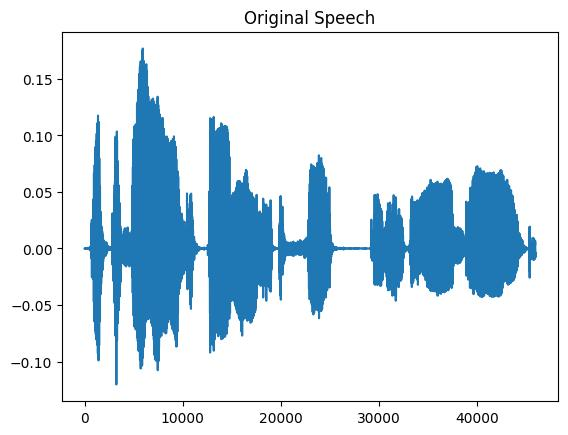

In [9]:
import matplotlib.pyplot as plt
from speechbrain.dataio.dataio import read_audio
signal = read_audio('spk1_snt1.wav')
plt.figure(1)
plt.title("Original Speech")
plt.plot(signal)
plt.show()

You can also play the audio

In [10]:
from IPython.display import Audio
Audio('spk1_snt1.wav')

We can now initalize the speed perturbator:

In [11]:
from speechbrain.augment.time_domain import SpeedPerturb

perturbator = SpeedPerturb(orig_freq=16000, speeds=[90])

The speed perturbator is a class that can be initialized with three parameters:


*   **orig_freq**: it is the sampling frequency of the original signal
*   **speeds**: It is a list with all the speeds that the signal should be changed to, as a percentage of the original signal (i.e, `speed=[100]` won't change the original signal). When adding more values (e.g, `speed=[90, 100, 110, 120]`) the speed will be randomly chosen among the specified values.

Let's now apply it to the original signal:

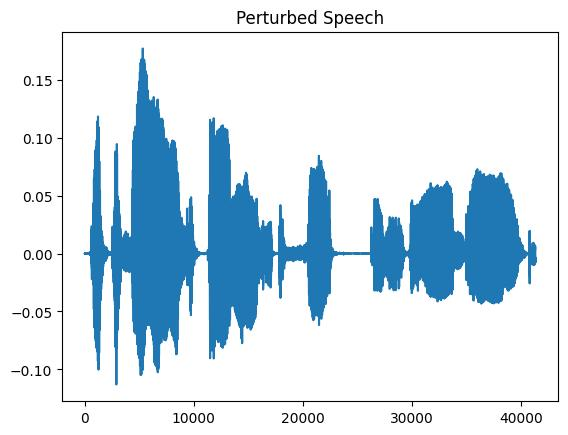

torch.Size([1, 45920])
torch.Size([1, 41328])


In [12]:
clean = signal.unsqueeze(0) # [batch, time]
perturbed = perturbator(clean)

plt.figure(1)
plt.title("Perturbed Speech")
plt.plot(perturbed.squeeze())
plt.show()

print(clean.shape)
print(perturbed.shape)

Audio(perturbed,rate=16000)


The perturbed tensor contains the signal with the perturbed speech. The change factor is 90% as can be observed from the shapes of the original vs perturbed signals (41328/45920 = 0.9)

One more thing to note is that this function supports multiple batches in input and the original signal must be unsqueezed to allocate the batch dimension in the first dimension of the tensor.


## 2. Time Dropout
Drop chunk replaces some random chunks of the original waveform with zeros. The intuition is that the neural network should provide good performance even when some piece of the signal is missing. Conceptually, this similar to **dropout**. The difference is that this is applied to the input waveform only. The other difference is that we drop consecutive samples rather than randomly selected elements like in dropout.

Let's see an example:

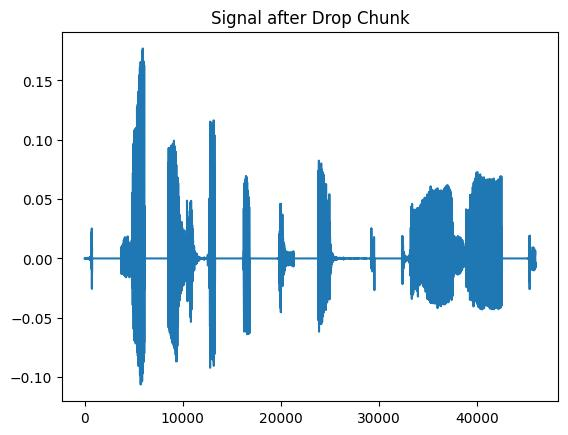

In [13]:
import torch
from speechbrain.augment.time_domain import DropChunk

dropper = DropChunk(drop_length_low=2000, drop_length_high=3000, drop_count_low=5, drop_count_high=10)
length = torch.ones(1)
dropped_signal = dropper(clean, length)

plt.figure(1)
plt.title("Signal after Drop Chunk")
plt.plot(dropped_signal.squeeze())
plt.show()

Audio(dropped_signal,rate=16000)


In the example above, we exaggerated a bit to make the effect more evident. The number of zeros can be managed by playing with the following parameters:

* **drop_length_low** and **drop_length_high** , that determines the maximum and minimum length of the random chunk of zeros.
* **drop_count_low** and **drop_count_high** , that affect the number of random chunks to add into the original signal

The length vector is needed because we can process in parallel batches of signals with different lengths. The length vector contains relative lengths for each sentence composing the batch (e.g, for two batches we can have lenght=[0.8 1.0] where 1.0 is the length of the longest sentence in the batch). In this case, we have a batch composed of a single sentence, and the relative length is thus length=[1.0].

## 3. Frequency Dropout
Drop Freq instead of adding zeros in the time domain, it adds zeros in the **frequency domain**. This can be achieved by filtering the original signal with **band-stop filters** randomly selected. Similarly to drop chunk, the intuition is that the neural network should work well even when some frequency channels are missing.




Text(0, 0.5, 'Frequency')

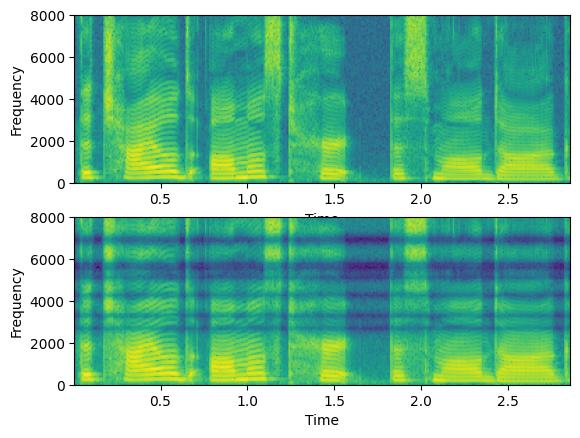

In [14]:
from speechbrain.augment.time_domain import DropFreq

dropper = DropFreq(drop_freq_count_low=5, drop_freq_count_high=8)
dropped_signal = dropper(clean)

# Let's plot the two spectrograms
plt.subplot(211)
plt.specgram(clean.squeeze(),Fs=16000)
plt.xlabel('Time')
plt.ylabel('Frequency')

plt.subplot(212)
plt.specgram(dropped_signal.squeeze(),Fs=16000)
plt.xlabel('Time')
plt.ylabel('Frequency')

The amount of frequency drop is controlled with the following parameters:


*   **drop_count_low**/**drop_count_high**, that impact on the number of frequency bands to drop.
*   **drop_freq_low**/**drop_freq_high**, that correspond to the minimum and maximum frequencies that can be dropped.  
*   **drop_width**, which corresponds to the width of the band to drop.

## 4. Clipping
Another way to remove some piece of information from a speech signal is to add clipping. It a form of non-linear distortions that clamps the max absolute amplitude of the signal (thus adding a saturation effect).



Text(0, 0.5, 'Frequency')

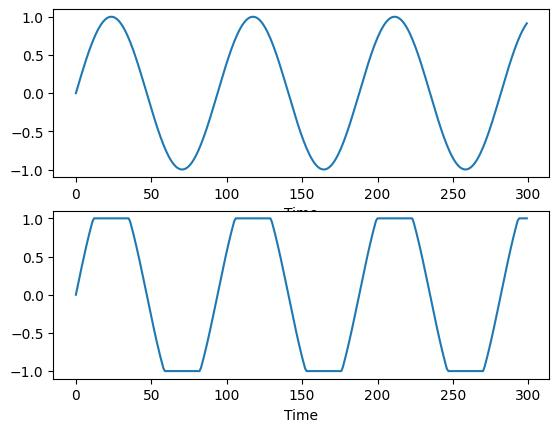

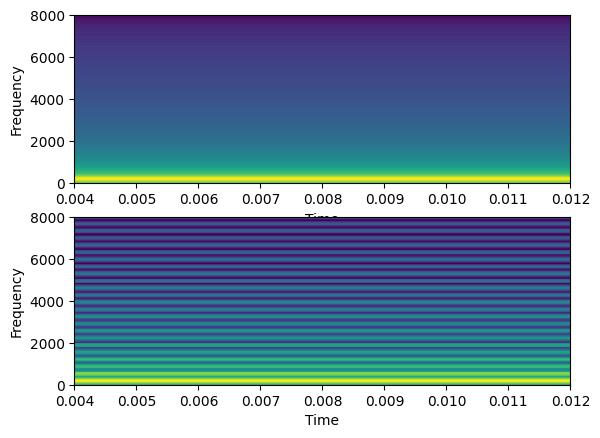

In [15]:
import torch
from speechbrain.augment.time_domain import DoClip

clipper = DoClip(clip_low=0.7, clip_high=0.7)
sinusoid = torch.sin(torch.linspace(0,20, 300))
clipped_signal = clipper(sinusoid.unsqueeze(0))

#  plots
plt.figure(1)
plt.subplot(211)
plt.plot(sinusoid)
plt.xlabel('Time')

plt.subplot(212)
plt.plot(clipped_signal.squeeze())
plt.xlabel('Time')

# freq domain
plt.figure(2)
plt.subplot(211)
plt.specgram(sinusoid,Fs=16000)
plt.xlabel('Time')
plt.ylabel('Frequency')

plt.subplot(212)
plt.specgram(clipped_signal.squeeze(),Fs=16000)
plt.xlabel('Time')
plt.ylabel('Frequency')





The amount of clipping is controlled with the parameters **clip_low** and **clip_high**, which set the lower and upper threshold over which the signal is clamped. In the frequency domain, clipping adds harmonics in the higher part of the spectrum.

## 5. Augmentation Combination

Let's consider the scenario where you aim to augmentation pipeline by integrating the previously defined augmentation techniques in a stochastic way.

This integration is facilitated by a dedicated class called `Augmenter` within the `speechbrain.augment `module.

For simplicity, let's examine a case where we want to combine the frequency dropper and the chunk dropper:

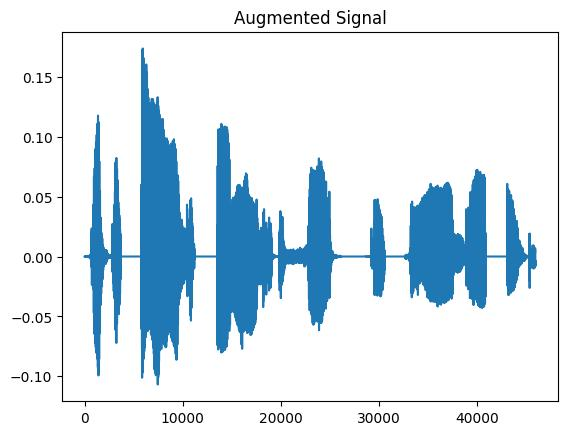

/home/sdelang/env/sb312/lib/python3.12/site-packages/matplotlib/axes/_axes.py:8089: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


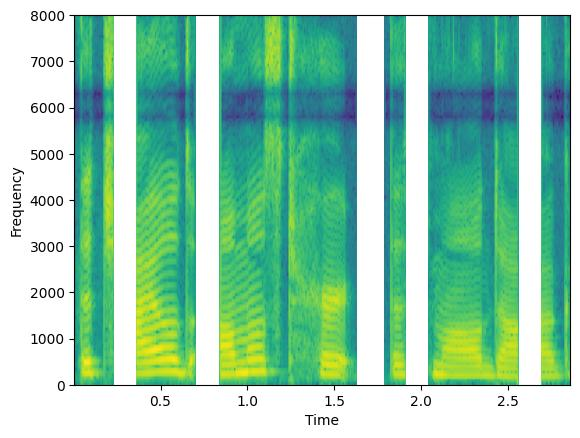

In [16]:
from speechbrain.augment.time_domain import DropFreq, DropChunk
from speechbrain.augment.augmenter import Augmenter

freq_dropper = DropFreq()
chunk_dropper = DropChunk(drop_length_low=2000, drop_length_high=3000, drop_count_low=5, drop_count_high=10)
augment = Augmenter(parallel_augment=False, concat_original=False, min_augmentations=2, max_augmentations=2,
                    shuffle_augmentations=False, repeat_augment=1,augmentations=[freq_dropper, chunk_dropper])

augmented_signal, lenghts = augment(clean, lengths=torch.tensor([1.0]))


plt.figure(1)
plt.title("Augmented Signal")
plt.plot(augmented_signal.squeeze())
plt.show()

plt.specgram(augmented_signal.squeeze(),Fs=16000)
plt.xlabel('Time')
plt.ylabel('Frequency')



Audio(augmented_signal,rate=16000)



The `Augmenter` accepts augmentation techniques through the `augmentations` argument and combines them to generate the augmented output.

Users have the flexibility to set various hyperparameters to tailor the augmentation strategy according to their preferences.

For example, by setting `parallel_augment=False`, the selected augmentations will be applied in a sequential pipeline. Conversely, if you opt for `parallel_augment=True`, each selected augmentation will produce a distinct augmented signal:




torch.Size([2, 45920])


/home/sdelang/env/sb312/lib/python3.12/site-packages/matplotlib/axes/_axes.py:8089: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


Text(0, 0.5, 'Frequency')

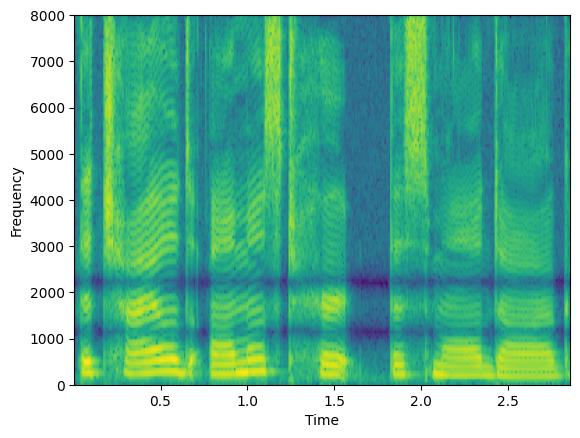

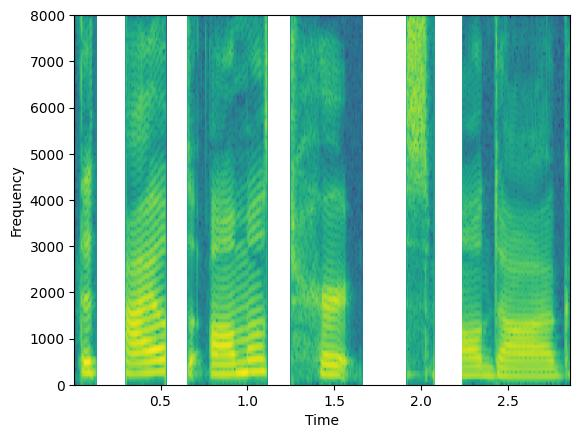

In [17]:
augment = Augmenter(parallel_augment=True, concat_original=False, min_augmentations=2, max_augmentations=2,
                    shuffle_augmentations=False, repeat_augment=1,augmentations=[freq_dropper, chunk_dropper])

augmented_signal, lenghts = augment(clean, lengths=torch.tensor([1.0]))

# We here have two signals, once for each augmentation
print(augmented_signal.shape)

plt.figure(1)
plt.specgram(augmented_signal[0],Fs=16000)
plt.xlabel('Time')
plt.ylabel('Frequency')

plt.figure(2)
plt.specgram(augmented_signal[1],Fs=16000)
plt.xlabel('Time')
plt.ylabel('Frequency')





The option `concat_original`  aurgment can be used to concatenate the original signal in the output batch.

torch.Size([3, 45920])


/home/sdelang/env/sb312/lib/python3.12/site-packages/matplotlib/axes/_axes.py:8089: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


Text(0, 0.5, 'Frequency')

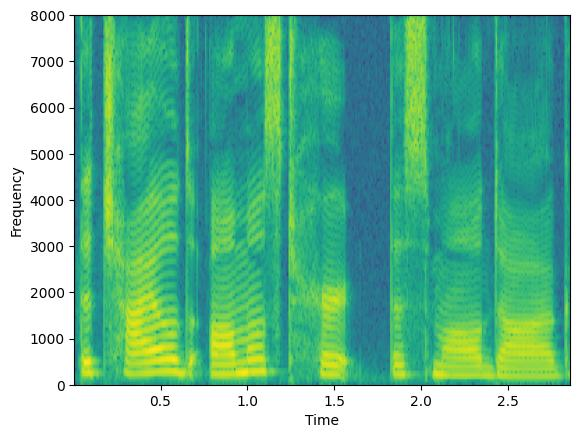

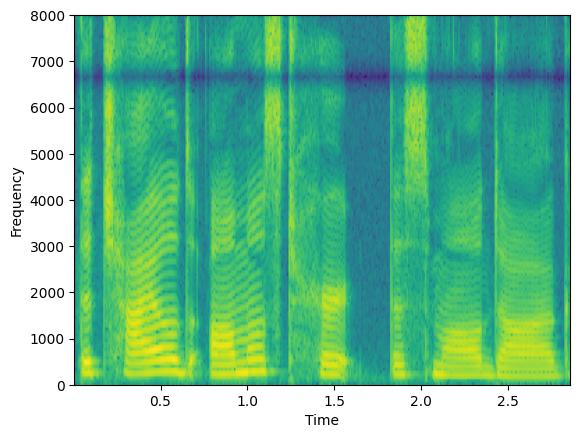

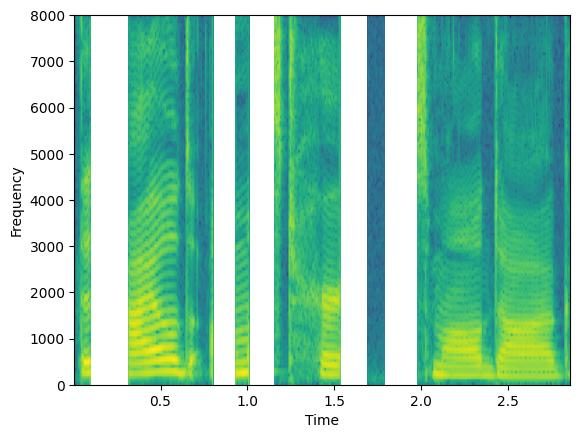

In [18]:
augment = Augmenter(parallel_augment=True, concat_original=True, min_augmentations=2, max_augmentations=2,
                    shuffle_augmentations=False, repeat_augment=1,augmentations=[freq_dropper, chunk_dropper])

augmented_signal, lenghts = augment(clean, lengths=torch.tensor([1.0]))

# We here have three signals: the orignal one + 2 augmentations
print(augmented_signal.shape)

plt.figure(1)
plt.specgram(augmented_signal[0],Fs=16000)
plt.xlabel('Time')
plt.ylabel('Frequency')

plt.figure(2)
plt.specgram(augmented_signal[1],Fs=16000)
plt.xlabel('Time')
plt.ylabel('Frequency')

plt.figure(3)
plt.specgram(augmented_signal[2],Fs=16000)
plt.xlabel('Time')
plt.ylabel('Frequency')

By manipulating the parameters min_augmentations and max_augmentations, we can apply a variable number of augmentations:

/home/sdelang/env/sb312/lib/python3.12/site-packages/matplotlib/axes/_axes.py:8089: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


Text(0, 0.5, 'Frequency')

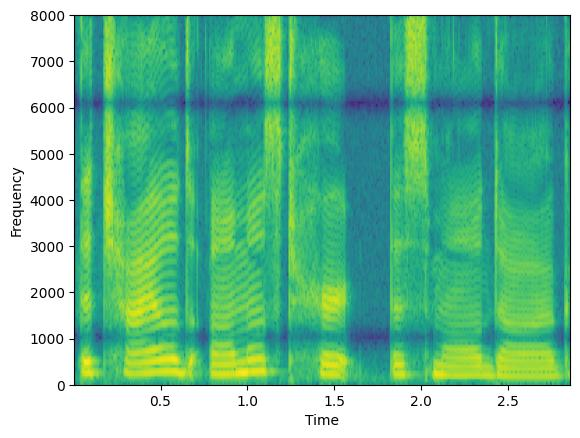

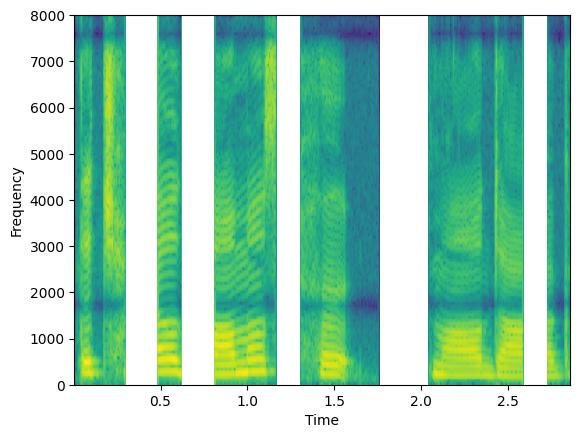

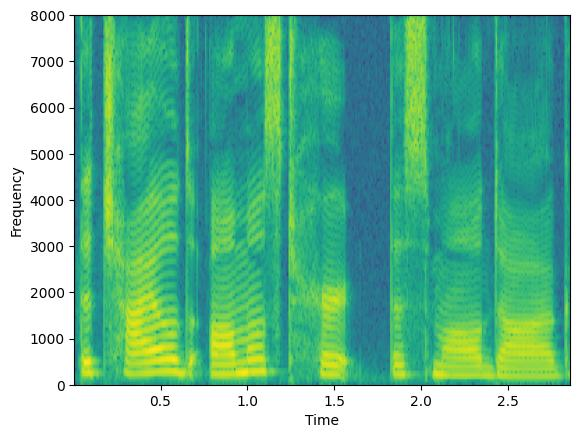

In [19]:
augment = Augmenter(parallel_augment=False, concat_original=False, min_augmentations=0, max_augmentations=2,
                    shuffle_augmentations=False, repeat_augment=1,augmentations=[freq_dropper, chunk_dropper])

augmented_signal1, lenghts = augment(clean, lengths=torch.tensor([1.0]))
augmented_signal2, lenghts = augment(clean, lengths=torch.tensor([1.0]))
augmented_signal3, lenghts = augment(clean, lengths=torch.tensor([1.0]))

plt.figure(1)
plt.specgram(augmented_signal1.squeeze(),Fs=16000)
plt.xlabel('Time')
plt.ylabel('Frequency')

plt.figure(2)
plt.specgram(augmented_signal2.squeeze(),Fs=16000)
plt.xlabel('Time')
plt.ylabel('Frequency')


plt.figure(3)
plt.specgram(augmented_signal3.squeeze(),Fs=16000)
plt.xlabel('Time')
plt.ylabel('Frequency')

In this instance, we have set `min_augmentations=0` and `max_augmentations=2` with `parallel_augment=False` and `concat_original=False`. Consequently, the output may contain a random number of augmentations applied in a sequential pipeline, varying between 0 (no augmentation) and 2 (e.g., drop frequency + drop chunk).

By incorporating `shuffle=True`, the order of augmentation application can be randomized (by default, it follows the order provided in the augmentation list). Additionally, the augmentation pipeline can be repeated multiple times, generating several augmented signals that are concatenated within the same batch.

For further details on the arguments, please refer to the documentation of the `Augmenter` class in `speechbrain.augment`.


## References
[1] Daniel S. Park, William Chan, Yu Zhang, Chung-Cheng Chiu, Barret Zoph, Ekin D. Cubuk, Quoc V. Le, *SpecAugment: A Simple Data Augmentation Method for Automatic Speech Recognition*, Proc. Interspeech 2019, [ArXiv](https://arxiv.org/abs/1904.08779)

[2] Mirco Ravanelli, Jianyuan Zhong, Santiago Pascual, Pawel Swietojanski, Joao Monteiro, Jan Trmal, Yoshua Bengio:
*Multi-Task Self-Supervised Learning for Robust Speech Recognition*. Proc. of ICASSP 2020 [ArXiv]()

## Citing SpeechBrain

If you use SpeechBrain in your research or business, please cite it using the following BibTeX entry:

```bibtex
@misc{speechbrainV1,
  title={Open-Source Conversational AI with {SpeechBrain} 1.0},
  author={Mirco Ravanelli and Titouan Parcollet and Adel Moumen and Sylvain de Langen and Cem Subakan and Peter Plantinga and Yingzhi Wang and Pooneh Mousavi and Luca Della Libera and Artem Ploujnikov and Francesco Paissan and Davide Borra and Salah Zaiem and Zeyu Zhao and Shucong Zhang and Georgios Karakasidis and Sung-Lin Yeh and Pierre Champion and Aku Rouhe and Rudolf Braun and Florian Mai and Juan Zuluaga-Gomez and Seyed Mahed Mousavi and Andreas Nautsch and Xuechen Liu and Sangeet Sagar and Jarod Duret and Salima Mdhaffar and Gaelle Laperriere and Mickael Rouvier and Renato De Mori and Yannick Esteve},
  year={2024},
  eprint={2407.00463},
  archivePrefix={arXiv},
  primaryClass={cs.LG},
  url={https://arxiv.org/abs/2407.00463},
}
@misc{speechbrain,
  title={{SpeechBrain}: A General-Purpose Speech Toolkit},
  author={Mirco Ravanelli and Titouan Parcollet and Peter Plantinga and Aku Rouhe and Samuele Cornell and Loren Lugosch and Cem Subakan and Nauman Dawalatabad and Abdelwahab Heba and Jianyuan Zhong and Ju-Chieh Chou and Sung-Lin Yeh and Szu-Wei Fu and Chien-Feng Liao and Elena Rastorgueva and François Grondin and William Aris and Hwidong Na and Yan Gao and Renato De Mori and Yoshua Bengio},
  year={2021},
  eprint={2106.04624},
  archivePrefix={arXiv},
  primaryClass={eess.AS},
  note={arXiv:2106.04624}
}
```